# Finding Correlation between potential factors (location and social issues) in Victoria

<b> Name: </b> Christian Hadinata Sugianto <br>
<b> Domain: </b> Crime

<b> Datasets: </b>

1. Crime Statistics Agency Data Tables - Crime by location (https://www.data.vic.gov.au/data/dataset/crime-by-location-data-table)
2. 2015 Local Government Area Profiles (https://www.data.vic.gov.au/data/dataset/2015-local-government-area-profiles)


<b> Question : </b> How does different location or social issues affect the crime rate level in Victoria?

<b> Steps : </b>
    1. Cleaning Datasets
    2. Integrating Datasets
    3. Data Visualisation
        - Look at how different locations in Victoria may affect crime rate (Outer vs Inner Region, Police Region)
        - Look at how social issues may affect crime rate in Victoria (Unemployment Rate, Number of Homeless people)
        - Classifying High Crime Level Local Government Area
        - Predicting High Crime Level Local Government Area

# Libraries

In [1]:
# Libraries for Processing Data
import pandas as pd
import numpy as np

# Libraries for Visualisation
import graphviz
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


# Libraries for Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Helper Functions

In [2]:
def VAT(R):
          
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
        
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)


    I = i[j]
    del J[I]

    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    
    C = [1,1]
    for r in range(2, N-1):   
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)        
        y = np.min(y)      
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])
    
    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)
    
    I.extend(J)
    C.extend(i)
    
    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    
    return RV.tolist(), C, I

def my_entropy(probs):
    return -probs.dot(np.log2(probs))
def mutual_info(X,Y):
    
    df = pd.DataFrame.from_dict({'X' : X,  'Y' :Y})
    Hx = my_entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = my_entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    
    counts = df.groupby(["X","Y"]).size()
    probs = counts/ counts.values.sum()
    H_xy = my_entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy)  
    return NMI

# Cleaning Datasets

In [3]:
x = pd.ExcelFile("Data Sheet.xlsx")
x3 = pd.ExcelFile("Data tables - Criminal Incidents Visualistion - year ending September 2017.xlsx")
print(x.sheet_names)
print(x3.sheet_names)

['LGAs', 'Area', 'Region', 'Division']
['Contents', 'Table 01and02', 'Table 03and04', 'Table 05and06', 'Table 07', 'Table 08', 'Table 09and10', 'Table 11']


<b> First DataFrame </b>

In [4]:
df_data = x.parse('LGAs')

In [5]:
# removing the symbols in the columns for easier processing
df_data = df_data.replace({'\$':''}, regex = True)
df_data = df_data.replace({'\%':''}, regex = True)

# change the formatting of the values in the column so that it can be matched with other DataFrame
df_data['LGA Name'].replace(regex=True,inplace=True,to_replace='\(S\)',value='')
df_data['LGA Name'].replace(regex=True,inplace=True,to_replace='\(B\)',value='')
df_data['LGA Name'].replace(regex=True,inplace=True,to_replace='\(C\)',value='')
df_data['LGA Name'].replace(regex=True,inplace=True,to_replace='\(RC\)',value='')
df_data['LGA Name'] = df_data['LGA Name'].str.upper()


In [6]:
# only including some relevant dimensions 
df_new_data = df_data[['LGA Name',
                        'LGA Code',
                        'Departmental Region',
                        'Departmental Area',
                        'Total offences per 1,000 population',
                        'Remoteness area',
                        'People born overseas', 
                        'Clients that received Alcohol & Drug Treatment Services per 1,000 population',
                        'Percentage of highly disadvantaged SA1s', 
                        'Low income families with children', 
                        'People with food insecurity',
                        'People who delayed purchasing prescribed medication, unable to afford',
                        'Households with rental stress',
                        'Unemployment rate',
                        'Families headed by one parent',
                        'Percentage of families headed by one parent - male',
                        'Percentage of families headed by one parent - female',
                        'Homeless people (estimated) per 1,000 population',
                        'People reporting fair or poor health status', 
                        'Females reporting fair or poor health status', 
                        'Males reporting fair or poor health status',
                        'Children with emotional or behavioural problems at school entry', 
                        'Children with speech or language problems at school entry', 
                        'Children developmentally vulnerable in one or more domains',
                        'People aged over 65 years with severe and profound disability living in the community',
                        'People reporting high/very high psychological distress', 
                        'People 19 years old having completed year 12',
                        'People who did not complete year 12',
                        'People who completed a higher education qualification']]

# renaming some of the column names
df_new_data.rename({'New dwellings approved per 1,000 population' : 'New dwellings per 1,000 population',
                    'People born overseas' : 'Percentage of People born overseas',
                    'Low income families with children' : 'Percentage of low income families with children',
                    'People who delayed purchasing prescribed medication, unable to afford': 
                        'Percentage of people who are unable to afford prescribed medication',
                    'Households with rental stress' : 'Percentage of households with rental stress',
                    'Families headed by one parent' : 'Percentage of Families headed by one parent',
                    'Children with emotional or behavioural problems at school entry' : 
                        'Percentage of children with emotional or behavioural problems at school entry', 
                    'Children with speech or language problems at school entry' : 
                        'Percentage of children with speech or language problems at school entry', 
                    'Children developmentally vulnerable in one or more domains' :
                        'Percentage of children devleopmentally vulnerable in one or more domains',    
                    'People aged over 65 years with severe and profound disability living in the community' :
                        'Percentage of people over 65 years old with severe and profound disability',
                    'People reporting fair or poor health status' : 
                        'Percentage of People Reporting fair or poor health status',
                    'Females reporting fair or poor health status' :
                        'Percentage of Female reporting fair or poor health status',
                    'Males reporting fair or poor health status' : 
                        'Percentage of Male reporting fair or poor health status',
                    'People reporting high/very high psychological distress' :
                        'Percentage of People reporting high/very high psychological distress',
                    'People with food insecurity' : 'Percentage of People with food insecurity',
                    'People 19 years old having completed year 12' : 
                        'Percentage of People 19 years old having completed year 12',
                    'People who did not complete year 12' : 
                        'Percentage of People who did not complete year 12',
                    'People who completed a higher education qualification' : 
                       'Percentage of People who completed a higher education qualification'},
                    axis = 1, inplace = True)

# dropping the row with Victoria since it is not a LGA
df_new_data = df_new_data.drop(df_new_data.index[79])

# converting potential numeric columns 
df_new_data = df_new_data.apply(pd.to_numeric, errors='ignore')

/Users/christianhadinata/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [7]:
# Checking for any missing values
df_new_data.isna().sum()

LGA Name                                                                         0
LGA Code                                                                         0
Departmental Region                                                              0
Departmental Area                                                                0
Total offences per 1,000 population                                              0
Remoteness area                                                                  0
Percentage of People born overseas                                               0
Clients that received Alcohol & Drug Treatment Services per 1,000 population     1
Percentage of highly disadvantaged SA1s                                          0
Percentage of low income families with children                                  0
Percentage of People with food insecurity                                        0
Percentage of people who are unable to afford prescribed medication              0
Perc

In [8]:
# Replacing the null values in the columns with the mean of each respective columns
df_new_data['Clients that received Alcohol & Drug Treatment Services per 1,000 population'].fillna(
        df_new_data['Clients that received Alcohol & Drug Treatment Services per 1,000 population'].mean(),
        inplace = True) 

df_new_data['Percentage of children with emotional or behavioural problems at school entry'].fillna(
        df_new_data['Percentage of children with emotional or behavioural problems at school entry'].mean(),
        inplace = True)

In [9]:
# Converting the column Total offences per 1,000 population into Crime Rate
tmp_lst = []
for i in df_new_data['Total offences per 1,000 population']:
    tmp_lst.append(i /10)

df_new_data['Crime Rate'] = tmp_lst

df_new_data.drop({'Total offences per 1,000 population'}, axis = 1, inplace = True)

In [10]:
# creating a new column for merged_df which includes crime level based on Crime Rate column
# 0 for low, 1 for medium, and 2 for high

tmp_lst = []
for i in df_new_data['Crime Rate']:
    if (i < df_new_data['Crime Rate'].quantile([0.67]).values[0]):
        tmp_lst.append(0)
    else:
        tmp_lst.append(1)
        
df_new_data['Crime Level'] = tmp_lst

df_new_data.head()

,LGA Name,LGA Code,Departmental Region,Departmental Area,Remoteness area,Percentage of People born overseas,"Clients that received Alcohol & Drug Treatment Services per 1,000 population",Percentage of highly disadvantaged SA1s,Percentage of low income families with children,Percentage of People with food insecurity,...,Percentage of children with emotional or behavioural problems at school entry,Percentage of children with speech or language problems at school entry,Percentage of children devleopmentally vulnerable in one or more domains,Percentage of people over 65 years old with severe and profound disability,Percentage of People reporting high/very high psychological distress,Percentage of People 19 years old having completed year 12,Percentage of People who did not complete year 12,Percentage of People who completed a higher education qualification,Crime Rate,Crime Level
0,ALPINE,20110.0,Hume,Ovens Murray,Outer Regional Australia,15.7,1.0,23.8,7.1,5.1,...,5.5,12.7,15.7,10.7,8.2,81.6,60.3,29.7,4.18,0
1,ARARAT,20260.0,Grampians,Central Highlands,Outer Regional Australia,9.2,11.5,45.5,11.0,5.9,...,6.5,14.8,17.8,11.5,10.1,81.3,64.0,26.8,10.95,1
2,BALLARAT,20570.0,Grampians,Central Highlands,Inner Regional Australia,9.1,5.5,31.5,11.9,3.1,...,6.9,17.0,21.1,13.0,11.9,75.5,52.6,38.1,11.24,1
3,BANYULE,20660.0,Northern Metropolitan,North Eastern Melbourne,Major Cities of Australia,23.1,3.7,8.3,6.2,2.4,...,3.0,12.5,16.5,13.0,9.6,91.1,37.6,52.8,7.20,0
4,BASS COAST,20740.0,Gippsland,Inner Gippsland,Inner Regional Australia,15.8,7.1,21.6,10.0,9.8,...,6.9,15.8,26.0,11.4,15.4,81.5,60.7,28.1,7.89,0


<b> Second DataFrame </b>

In [11]:
df_crime = x3.parse('Table 03and04')

In [12]:
# making a dictionary which stores 'LGA Name' as key and 'LGA Code' as its item 
dictionary = {}
for i in df_new_data['LGA Name']:
    dictionary[i] = df_new_data.loc[df_new_data['LGA Name'] == i]['LGA Code'].values[0]

# creating a new column for df_crime which includes LGA Code based on its LGA Name  
tmp_lst = []
for i in df_crime['Local Government Area']:
    if (i + " ") in dictionary:
        tmp_lst.append(dictionary[i + " "])
    else:
        tmp_lst.append(np.nan)
        
df_crime['LGA Code'] = tmp_lst

In [13]:
df_crime.head()

,Year ending September,Police Region,Local Government Area,Incidents Recorded,ERP,LGA Code
0,2017,1 NORTH WEST METRO,BANYULE,7464,128469,20660.0
1,2017,1 NORTH WEST METRO,BRIMBANK,13323,203260,21180.0
2,2017,1 NORTH WEST METRO,DAREBIN,11965,156312,21890.0
3,2017,1 NORTH WEST METRO,HOBSONS BAY,4943,94434,23110.0
4,2017,1 NORTH WEST METRO,HUME,15467,205594,23270.0


# Datasets Integration 

In [14]:
# creates a new dataframe which includes LGA Code and the incidents recorded in the LGA
df_crime_lga = pd.DataFrame({'Police Region' : df_crime.groupby('LGA Code')['Police Region']})

lga_lst = []
police_lst = []
for i in range(0, len(df_crime_lga['Police Region'])):
    lga_lst.append(df_crime_lga['Police Region'][i][0])
    police_lst.append(df_crime_lga['Police Region'][i][1].values[0])

df_crime_new = pd.DataFrame({'LGA Code' : lga_lst, 'Police Region' : police_lst})

In [15]:
# merging two dataframes based on LGA Code
merged_df = pd.merge(df_new_data, df_crime_new, on = ['LGA Code'])

# converting potential numeric columns 
merged_df = merged_df.apply(pd.to_numeric, errors='ignore')

In [16]:
merged_df.head()

,LGA Name,LGA Code,Departmental Region,Departmental Area,Remoteness area,Percentage of People born overseas,"Clients that received Alcohol & Drug Treatment Services per 1,000 population",Percentage of highly disadvantaged SA1s,Percentage of low income families with children,Percentage of People with food insecurity,...,Percentage of children with speech or language problems at school entry,Percentage of children devleopmentally vulnerable in one or more domains,Percentage of people over 65 years old with severe and profound disability,Percentage of People reporting high/very high psychological distress,Percentage of People 19 years old having completed year 12,Percentage of People who did not complete year 12,Percentage of People who completed a higher education qualification,Crime Rate,Crime Level,Police Region
0,ALPINE,20110.0,Hume,Ovens Murray,Outer Regional Australia,15.7,1.0,23.8,7.1,5.1,...,12.7,15.7,10.7,8.2,81.6,60.3,29.7,4.18,0,2 EASTERN
1,ARARAT,20260.0,Grampians,Central Highlands,Outer Regional Australia,9.2,11.5,45.5,11.0,5.9,...,14.8,17.8,11.5,10.1,81.3,64.0,26.8,10.95,1,4 WESTERN
2,BALLARAT,20570.0,Grampians,Central Highlands,Inner Regional Australia,9.1,5.5,31.5,11.9,3.1,...,17.0,21.1,13.0,11.9,75.5,52.6,38.1,11.24,1,4 WESTERN
3,BANYULE,20660.0,Northern Metropolitan,North Eastern Melbourne,Major Cities of Australia,23.1,3.7,8.3,6.2,2.4,...,12.5,16.5,13.0,9.6,91.1,37.6,52.8,7.20,0,1 NORTH WEST METRO
4,BASS COAST,20740.0,Gippsland,Inner Gippsland,Inner Regional Australia,15.8,7.1,21.6,10.0,9.8,...,15.8,26.0,11.4,15.4,81.5,60.7,28.1,7.89,0,2 EASTERN


# Data Visualisation

<b> Comparing number of LGA with high crime level based on Remoteness area </b>

<Figure size 432x288 with 0 Axes>

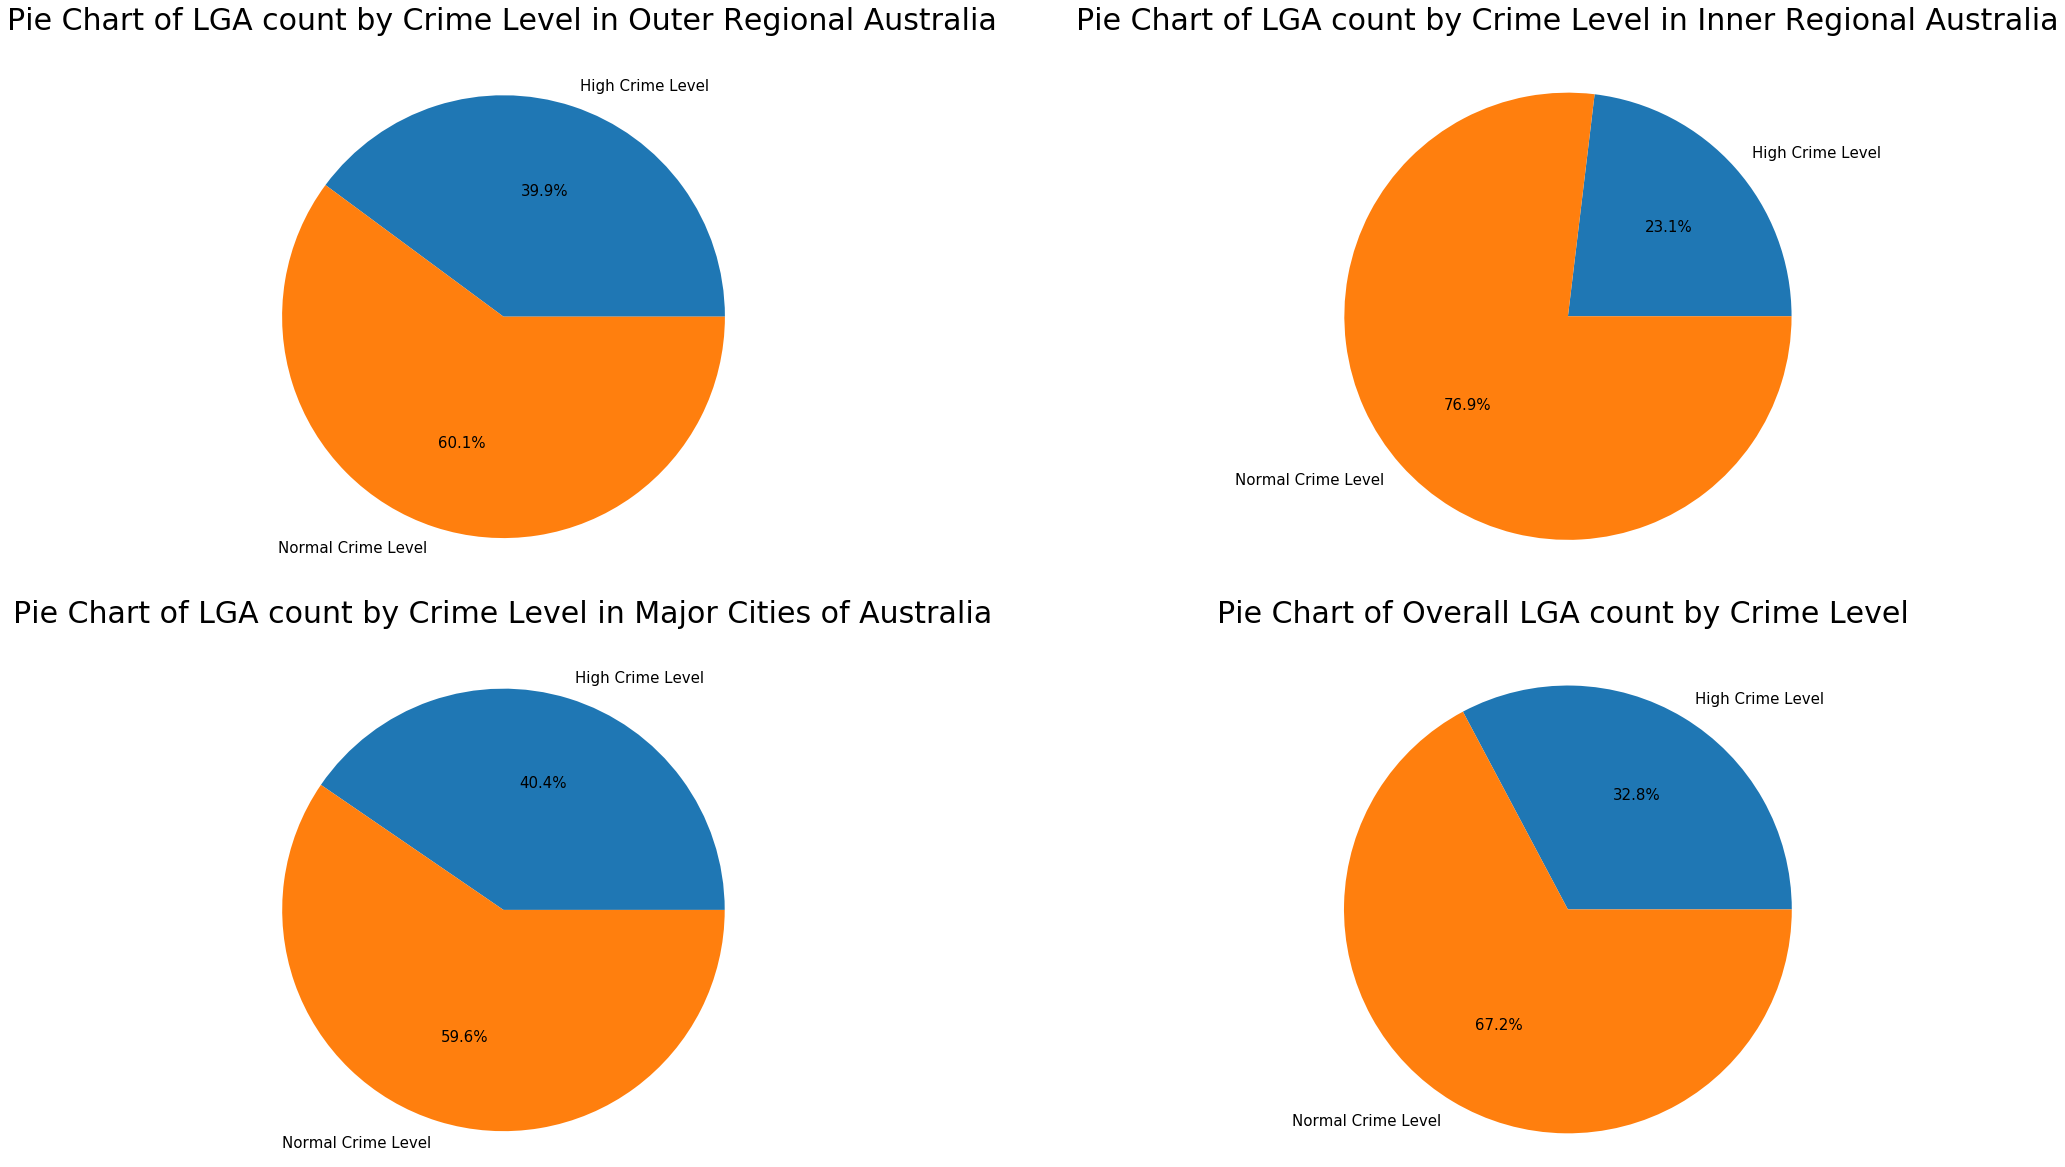

In [17]:
# getting the number of LGA by Crime Level
test_df = merged_df.copy()

test_df['Crime Level'] = test_df['Crime Level'].replace(0,'Normal Crime Level')
test_df['Crime Level'] = test_df['Crime Level'].replace(1,'High Crime Level')

# divide DataFrame based on Remoteness area
test_df1 = test_df[test_df['Remoteness area'] == 'Outer Regional Australia']
test_df2 = test_df[test_df['Remoteness area'] == 'Inner Regional Australia']
test_df3 = test_df[test_df['Remoteness area'] == 'Major Cities of Australia']

# group by Crime Level while adding the number of LGA within the Crime Level
test_df1 = pd.DataFrame({'LGA Code' : test_df1.groupby(['Crime Level'])["LGA Code"].sum()})
test_df1 = test_df1.reset_index()

test_df2 = pd.DataFrame({'LGA Code' : test_df2.groupby(['Crime Level'])["LGA Code"].sum()})
test_df2 = test_df2.reset_index()

test_df3 = pd.DataFrame({'LGA Code' : test_df3.groupby(['Crime Level'])["LGA Code"].sum()})
test_df3 = test_df3.reset_index()

test_df4 = pd.DataFrame({'LGA Code' : test_df.groupby(['Crime Level'])["LGA Code"].sum()})
test_df4 = test_df4.reset_index()

#plot
plt.clf()
plt.rcParams['figure.figsize'] = (35, 20)
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2)

axes[0,0].set_title("Pie Chart of LGA count by Crime Level in Outer Regional Australia\n", fontsize = 30)
axes[0,0].pie(test_df1['LGA Code'], labels = test_df1['Crime Level'], autopct='%1.1f%%')
axes[0,0].axis('equal')

axes[0,1].set_title("Pie Chart of LGA count by Crime Level in Inner Regional Australia\n", fontsize = 30)
axes[0,1].pie(test_df2['LGA Code'], labels = test_df2['Crime Level'], autopct='%1.1f%%')
axes[0,1].axis('equal')

axes[1,0].set_title("Pie Chart of LGA count by Crime Level in Major Cities of Australia\n", fontsize = 30)
axes[1,0].pie(test_df3['LGA Code'], labels = test_df3['Crime Level'], autopct='%1.1f%%')
axes[1,0].axis('equal')

axes[1,1].set_title("Pie Chart of Overall LGA count by Crime Level \n", fontsize = 30)
axes[1,1].pie(test_df4['LGA Code'], labels = test_df4['Crime Level'], autopct='%1.1f%%')
axes[1,1].axis('equal')

plt.show()

From the pie charts, we can see a pattern where LGA in Major Cities of Australia are more likely to be categorised as high crime Level while LGA in Outer Regional Australia are not very different to the ones in Major Cities of Australia with 4% less of the LGA have high crime level. However, the LGA in Inner Regional Australia are more likely to have normal crime level compared to the other two area remoteness. As for the Pie Chart of Overall LGA count by Crime Level, the top 30% of LGA has high crime level while the rest has low crime level, which is based on the division done in the pre-processing

<b> Comparing number of LGA with high crime level based on Police Region </b>

<Figure size 2520x1440 with 0 Axes>

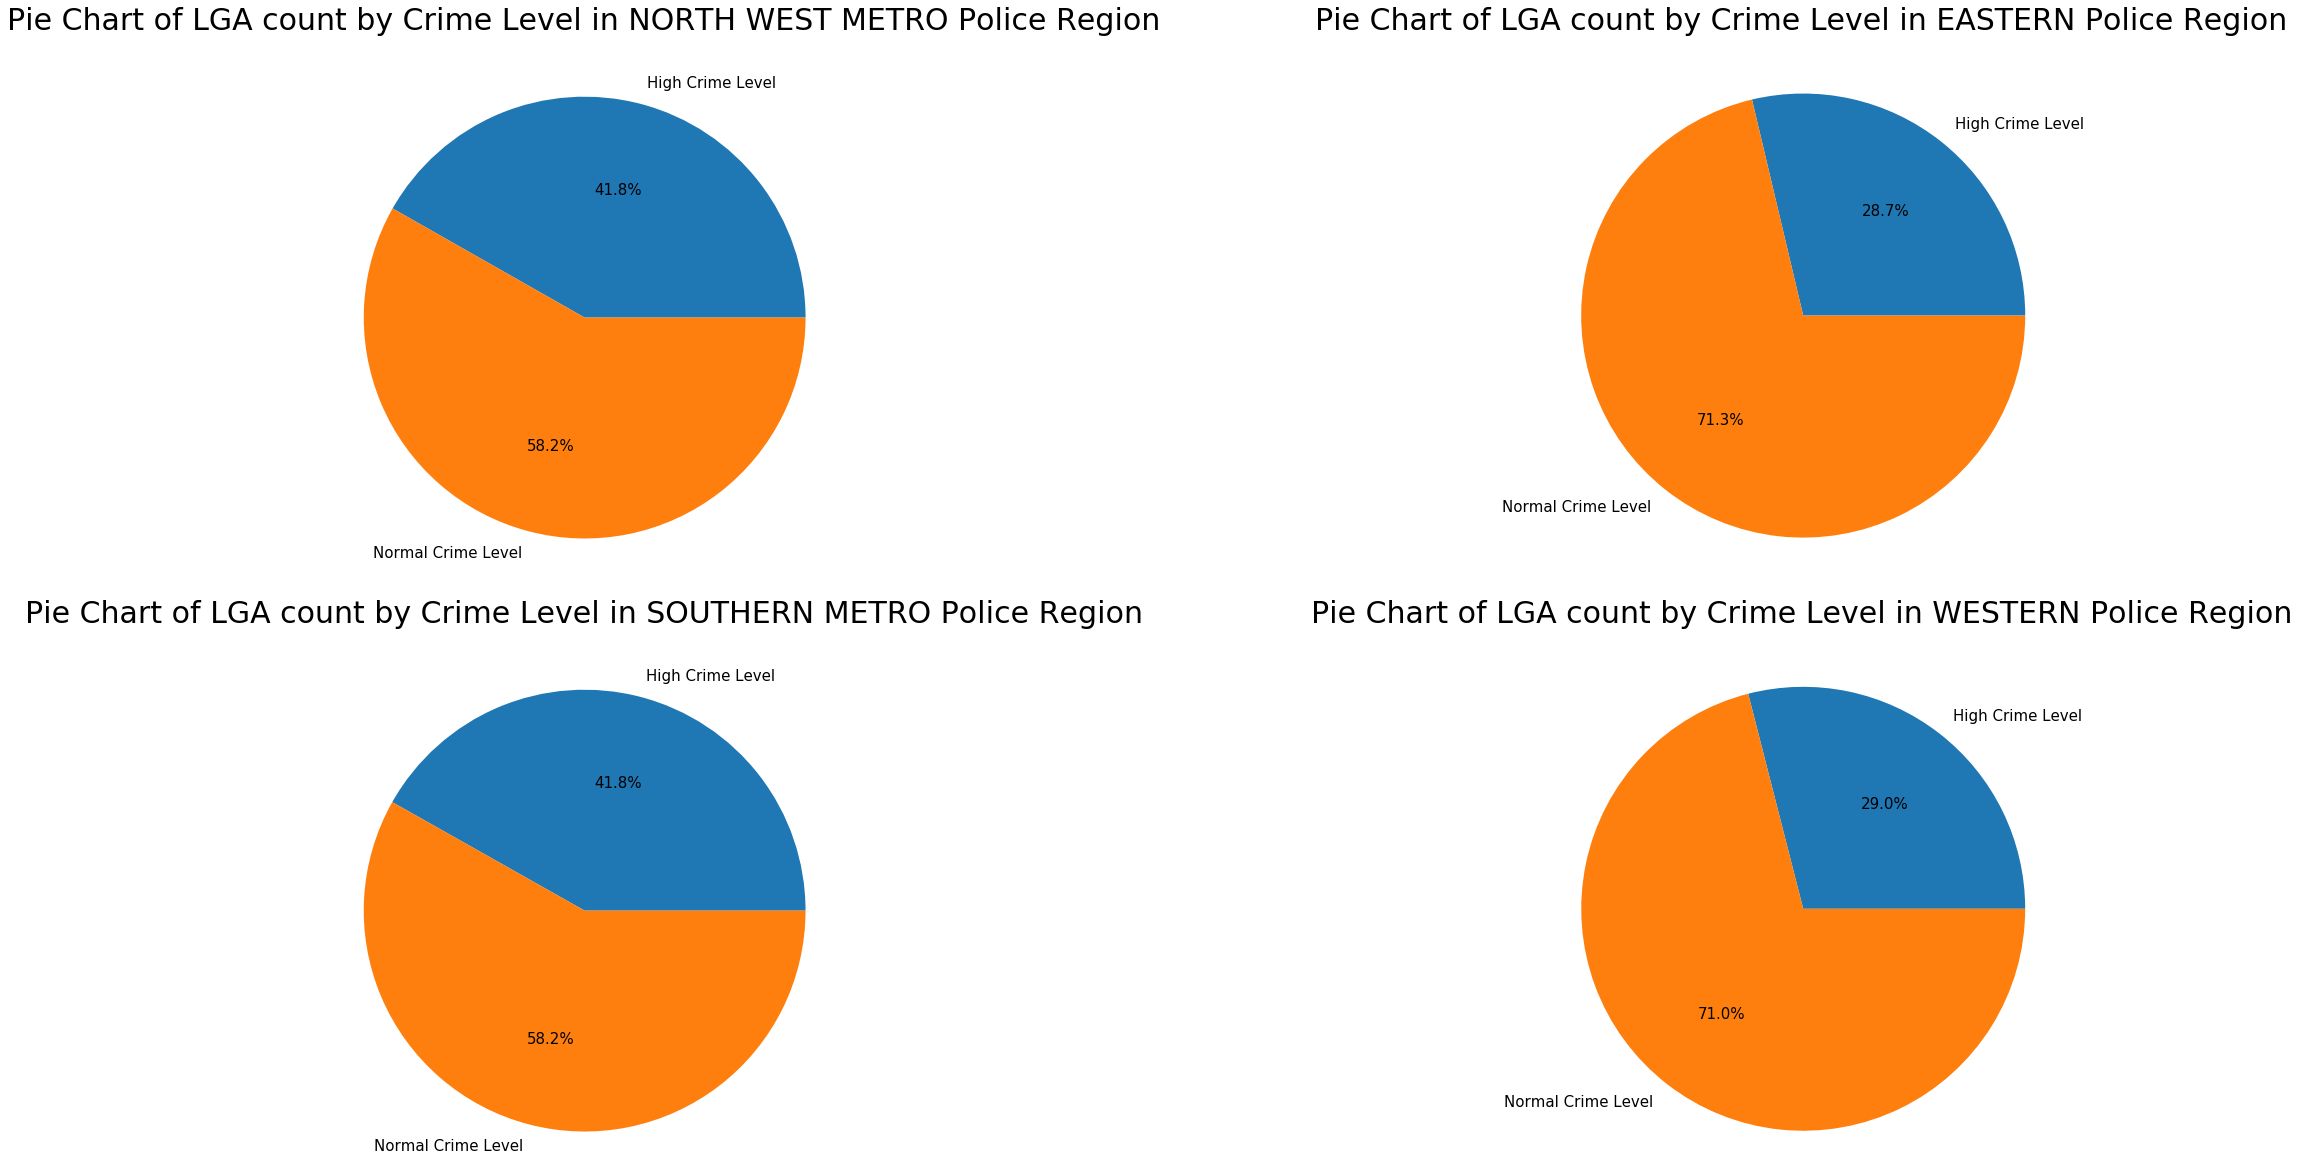

In [18]:
# getting the number of LGA by Crime Level
test_df = merged_df.copy()

test_df['Crime Level'] = test_df['Crime Level'].replace(0,'Normal Crime Level')
test_df['Crime Level'] = test_df['Crime Level'].replace(1,'High Crime Level')

# divide DataFrame based on Remoteness area
test_df1 = test_df[test_df['Police Region'] == '1 NORTH WEST METRO']
test_df2 = test_df[test_df['Police Region'] == '2 EASTERN']
test_df3 = test_df[test_df['Police Region'] == '3 SOUTHERN METRO']
test_df4 = test_df[test_df['Police Region'] == '4 WESTERN']

# group by Crime Level while adding the number of LGA within the Crime Level
test_df1 = pd.DataFrame({'LGA Code' : test_df1.groupby(['Crime Level'])["LGA Code"].sum()})
test_df1 = test_df1.reset_index()

test_df2 = pd.DataFrame({'LGA Code' : test_df2.groupby(['Crime Level'])["LGA Code"].sum()})
test_df2 = test_df2.reset_index()

test_df3 = pd.DataFrame({'LGA Code' : test_df3.groupby(['Crime Level'])["LGA Code"].sum()})
test_df3 = test_df3.reset_index()

test_df4 = pd.DataFrame({'LGA Code' : test_df4.groupby(['Crime Level'])["LGA Code"].sum()})
test_df4 = test_df4.reset_index()

#plot
plt.clf()
plt.rcParams['figure.figsize'] = (40, 20)
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2)

axes[0,0].set_title("Pie Chart of LGA count by Crime Level in NORTH WEST METRO Police Region\n", fontsize = 30)
axes[0,0].pie(test_df1['LGA Code'], labels = test_df1['Crime Level'], autopct='%1.1f%%')
axes[0,0].axis('equal')

axes[0,1].set_title("Pie Chart of LGA count by Crime Level in EASTERN Police Region\n", fontsize = 30)
axes[0,1].pie(test_df2['LGA Code'], labels = test_df2['Crime Level'], autopct='%1.1f%%')
axes[0,1].axis('equal')

axes[1,0].set_title("Pie Chart of LGA count by Crime Level in SOUTHERN METRO Police Region\n", fontsize = 30)
axes[1,0].pie(test_df3['LGA Code'], labels = test_df3['Crime Level'], autopct='%1.1f%%')
axes[1,0].axis('equal')

axes[1,1].set_title("Pie Chart of LGA count by Crime Level in WESTERN Police Region\n", fontsize = 30)
axes[1,1].pie(test_df4['LGA Code'], labels = test_df4['Crime Level'], autopct='%1.1f%%')
axes[1,1].axis('equal')

plt.show()

From the pie charts, we can see a pattern where the High Crime Level LGA in Southern and North West Metro of Police Region is much higher compared to the High Crime Level LGA in Western and Eastern Police Region

<b> Checking Distribution of Different Crime Level </b>

Text(0,0.5,'Crime Rate (%)')

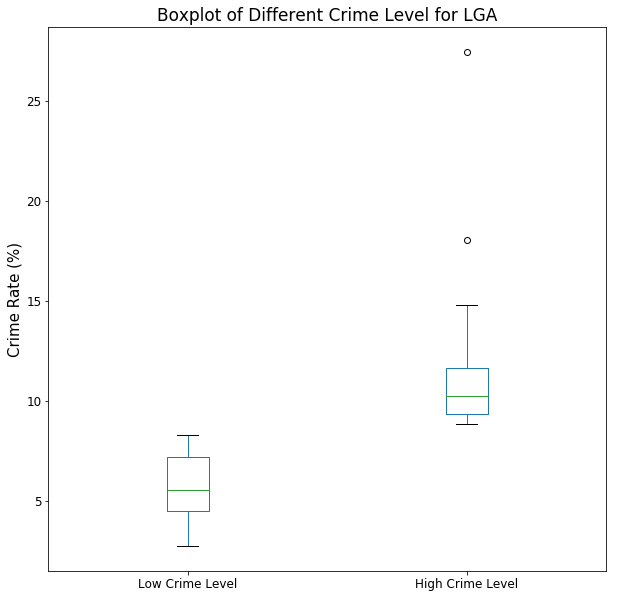

In [19]:
# dividing merged_df based on Remoteness Area
df_low = merged_df[merged_df['Crime Level'] == 0]
df_high = merged_df[merged_df['Crime Level'] == 1]

# only includes the Crime Rate from the DataFrames
df_test = pd.DataFrame({'Low Crime Level': df_low['Crime Rate'], 
                        'High Crime Level': df_high['Crime Rate']})

# plot
df_test.boxplot(grid = False, figsize = (10,10), fontsize = 12)
plt.title('Boxplot of Different Crime Level for LGA', fontsize = 17)
plt.ylabel("Crime Rate (%)", fontsize = 15)

<b> Checking the correlations of some potential factors which increases crime rate </b>

<Figure size 2880x1440 with 0 Axes>

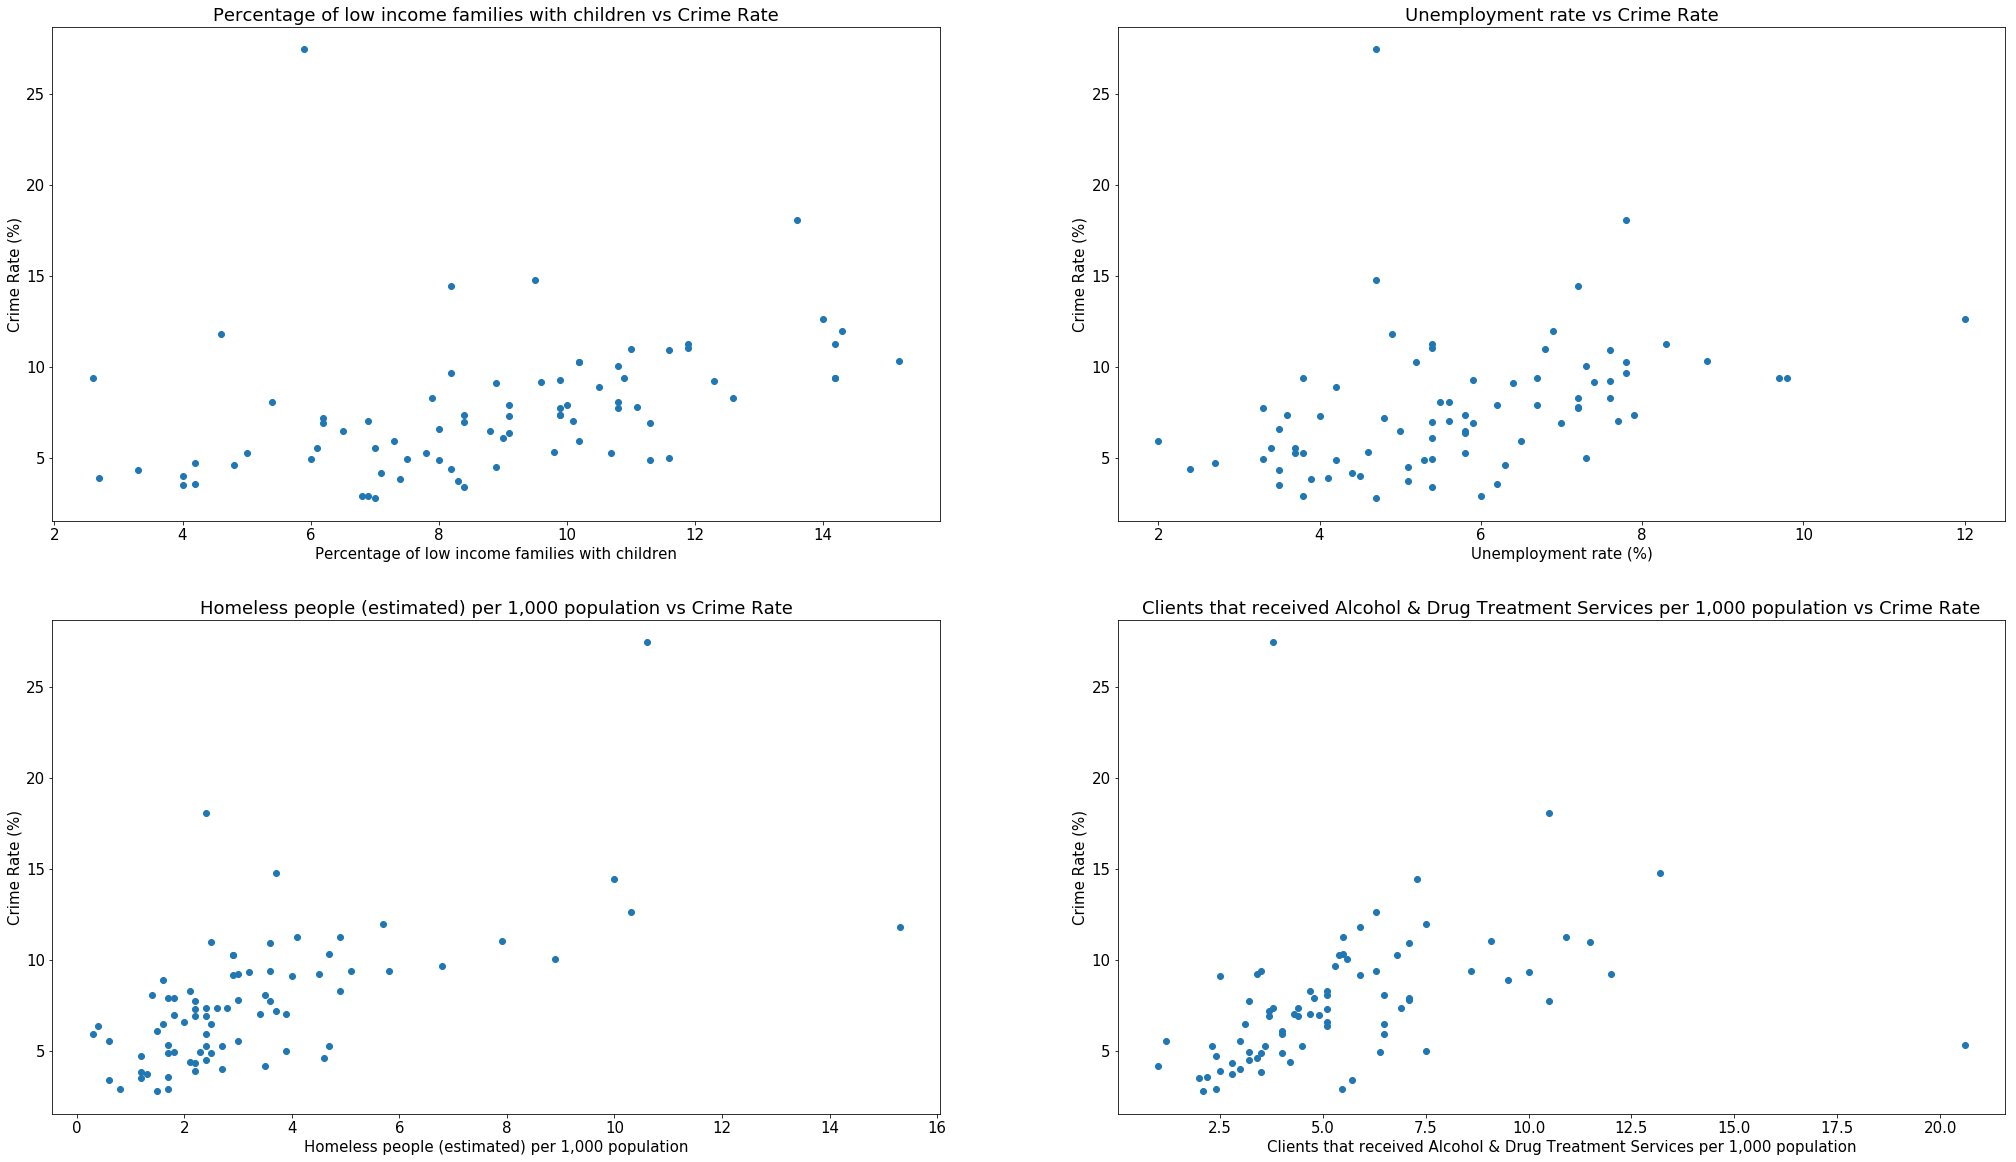

In [20]:
# plot 
plt.clf()
plt.rcParams['figure.figsize'] = (35, 20)
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2)

axes[0,0].set_title('Percentage of low income families with children vs Crime Rate')
axes[0,0].set_xlabel('Percentage of low income families with children')
axes[0,0].set_ylabel('Crime Rate (%)')
axes[0,0].scatter(merged_df['Percentage of low income families with children'], 
                merged_df['Crime Rate'])

axes[0,1].set_title('Unemployment rate vs Crime Rate')
axes[0,1].set_xlabel('Unemployment rate (%)')
axes[0,1].set_ylabel('Crime Rate (%)')
axes[0,1].scatter(merged_df['Unemployment rate'], 
                merged_df['Crime Rate'])

axes[1,0].set_title('Homeless people (estimated) per 1,000 population vs Crime Rate')
axes[1,0].set_xlabel('Homeless people (estimated) per 1,000 population')
axes[1,0].set_ylabel('Crime Rate (%)')
axes[1,0].scatter(merged_df['Homeless people (estimated) per 1,000 population'],
                 merged_df['Crime Rate'])

axes[1,1].set_title('Clients that received Alcohol & Drug Treatment Services per 1,000 population vs Crime Rate')
axes[1,1].set_xlabel('Clients that received Alcohol & Drug Treatment Services per 1,000 population')
axes[1,1].set_ylabel('Crime Rate (%)')
axes[1,1].scatter(merged_df['Clients that received Alcohol & Drug Treatment Services per 1,000 population'], 
                merged_df['Crime Rate'])
plt.show()


It can be seen that 'Total offences per 1,000 population' (crime rate) has positive correlation with all of the other attributes. From the table, crime rate has medium positive correlation with 'Clients that received Alcohold & Drug Treatment Services per 1,000 population', 'Unemployment Rate' and 'Percentage of low income familes with children'. Additionally, it has very strong positive correlation with number of homeless people per 1,000 population. 

It makes sense how crime rate can increase due to unemployment rate because the higher the unemployment rate indicates that people not able to find work to make a living, so instead they do crime to gain money. Whereas people who have low income are more easily tempted to do crimes as well because of the low amount of earnings they get. Furthermore, homeless people are more likely to do crime as well because homeless people tend to be unemployed. Besides that, the number of clients receiving Alcohol and Drug Treatment Services can be used to estimate the number of the people consuming drug and alcohol in the LGA. Thus, drug and alcohol consumption is also expected to have positive correlation with crime rate because it is general knowledge that excess consumption of alcohol or consumption of drug would lead to higher crime rate because people with limited fund would be encouraged to do crime to earn money for drug and alcohol consumption

Even though correlation does not imply causality, it is reasonable to conclude that poverty, unemployment rate, drug and alcohol consumption, and number of homeless people have positive linear relationship with crime rate


<b> Feature Scaling </b>

In [21]:
df = merged_df.copy()

df['Outer Regional Australia'] = pd.Series(df["Remoteness area"].replace({
                                            'Outer Regional Australia': 1, 
                                            'Inner Regional Australia': 0,
                                            'Major Cities of Australia': 0}))

df['Inner Regional Australia'] = pd.Series(df["Remoteness area"].replace({
                                            'Outer Regional Australia': 0, 
                                            'Inner Regional Australia': 1,
                                            'Major Cities of Australia': 0}))

df['Major Cities of Australia'] = pd.Series(df["Remoteness area"].replace({
                                            'Outer Regional Australia': 0, 
                                            'Inner Regional Australia': 0,
                                            'Major Cities of Australia': 1}))


# dropping the unnecessary columns from the DataFrame 
df.drop({'LGA Name', 'LGA Code', 'Departmental Region', 'Departmental Area', 'Remoteness area',
         'Crime Rate', 'Police Region'}, axis = 1, inplace = True)

# create matrix X
cols = [col for col in df.columns if col != 'Crime Level']
X = df[cols]

# create vector y
y = df['Crime Level']

# normalise the features matrix X
X_scaled = StandardScaler().fit_transform(X)

print('***')
print('Shape:', X_scaled.shape)
print('Min: %.4f'% X_scaled.min())
print('Max: %.4f'% X_scaled.max())
print('Average: %.4f'% X_scaled.mean())
print('Standard Deviation: %.4f'% X_scaled.std())
print('***')

***
Shape: (79, 26)
Min: -4.4460
Max: 4.8992
Average: 0.0000
Standard Deviation: 1.0000
***


/Users/christianhadinata/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/christianhadinata/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


<b> Dimension Reduction: PCA </b>

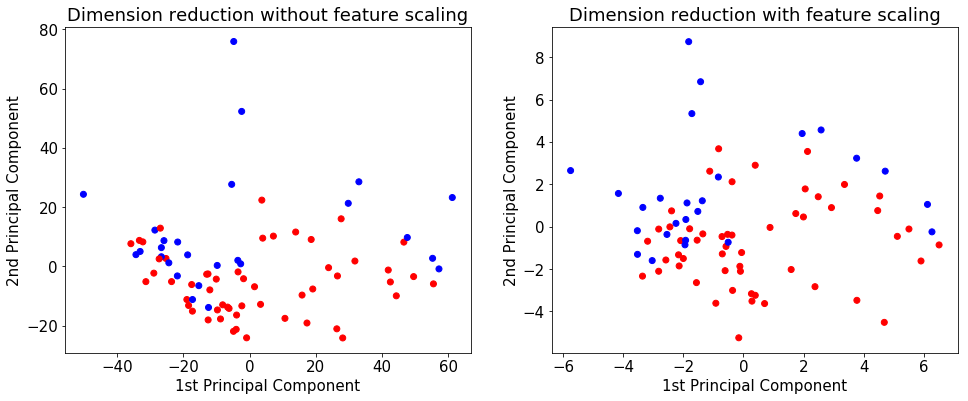

In [22]:
# using PCA for Dimension Reduction
X_reduced = PCA(n_components=2).fit_transform(X)
X_scaled_reduced = PCA(n_components=2).fit_transform(X_scaled)

# Color the Low Crime Level LGA with red while High Level Crime Level LGA with blue
colors = y.replace([0,1,2],['red','blue', 'green'])

# plot
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

# Visualise with scatterplots
axes[0].scatter(X_reduced[:,0], X_reduced[:,1], c = colors)
axes[0].set(title = 'Dimension reduction without feature scaling',
        xlabel = '1st Principal Component', 
        ylabel = '2nd Principal Component')

axes[1].scatter(X_scaled_reduced[:,0], X_scaled_reduced[:,1], c=colors)
axes[1].set(title = 'Dimension reduction with feature scaling',
        xlabel = '1st Principal Component',
        ylabel = '2nd Principal Component')

plt.show()

In the plot with feature scaling, it can be seen that there is not much change even with the PCA for 2 ncomponents. Even though many features have already been reduced, there is still wide spread within the plots. While reducing dimensions always result in losing information, using PCA dimensionality reduction helps in minimizing the information loss. 

<b> Looking at Correlations between Attributes </b>

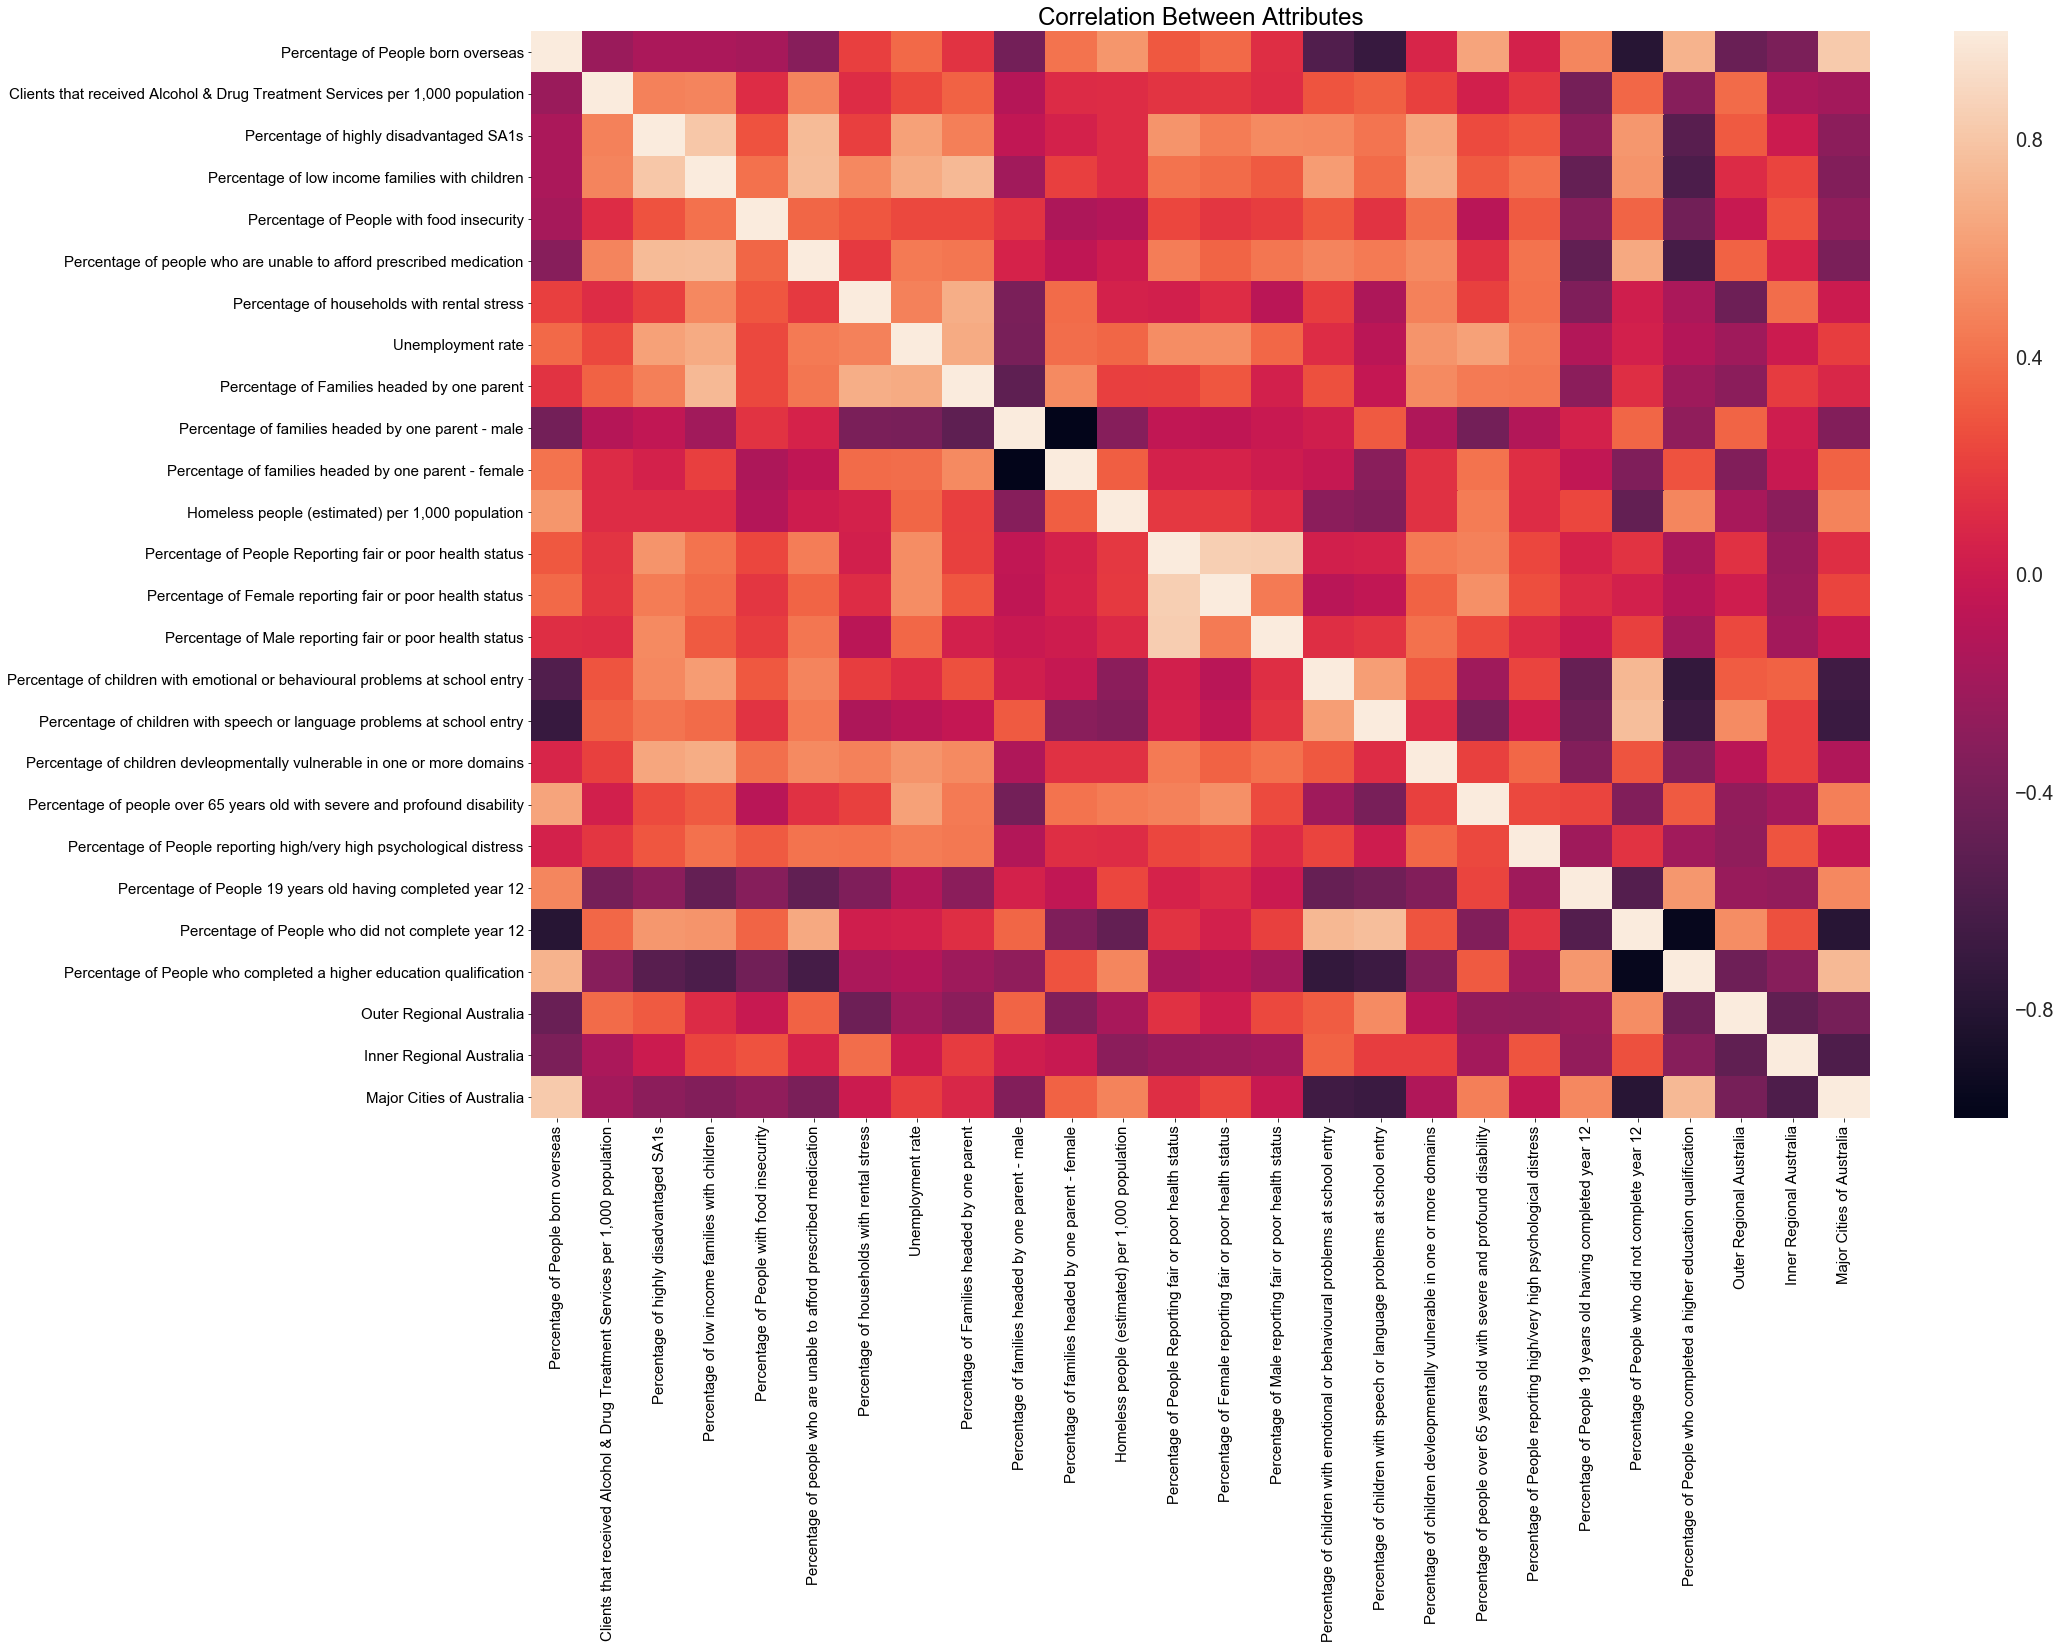

In [23]:
# converting into dataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# plot 
fig, ax = plt.subplots(figsize = (30,20))
sns.set(font_scale = 2)

# visualise with heatmap
sns.heatmap(X_scaled_df.corr(), label=df.columns)
plt.title("Correlation Between Attributes")

plt.show()

From the heatmap, interesting facts that can be seen are:
1. Homeless people (estimated) per 1,000 population has high correlation with unemployment rate which is as expected. However, it also has high correlation with 'Percentage of People born overseas', this means that there is possibility that number of homeless people increases by the number of people of born overseas.
2. Clients that received Alcohold & Drug Treatment Services per 1,000 population has high correlation with 'Percentage of low income families with children' and 'Percentage of people who are unable to afford prescribed medication'. This suggests that there is possibility that people who are having financial difficulties are more likely to drink alcohol or use drug, which would push them even more to do crime.
3. Percentage of People who did not complete year 12 has high correlation with 'Percentage of low income families with children' and 'Percentage of people who are unable to afford prescribed medication'. This makes sense because people who did not finish their studies are more likely to find trouble in finding jobs, which would lead to them doing crimes instead. The cause of this may also be seen from its' high correlation with 'Percentage of children with emotional or behavioural problems at school entry' and 'Percentage of Children with speech or language or language problems at school entry', which indicates that children who have emotional or behavioural problems or problem in speech, might not finish their studies later on.

<b> Hierarchical Clustering </b>

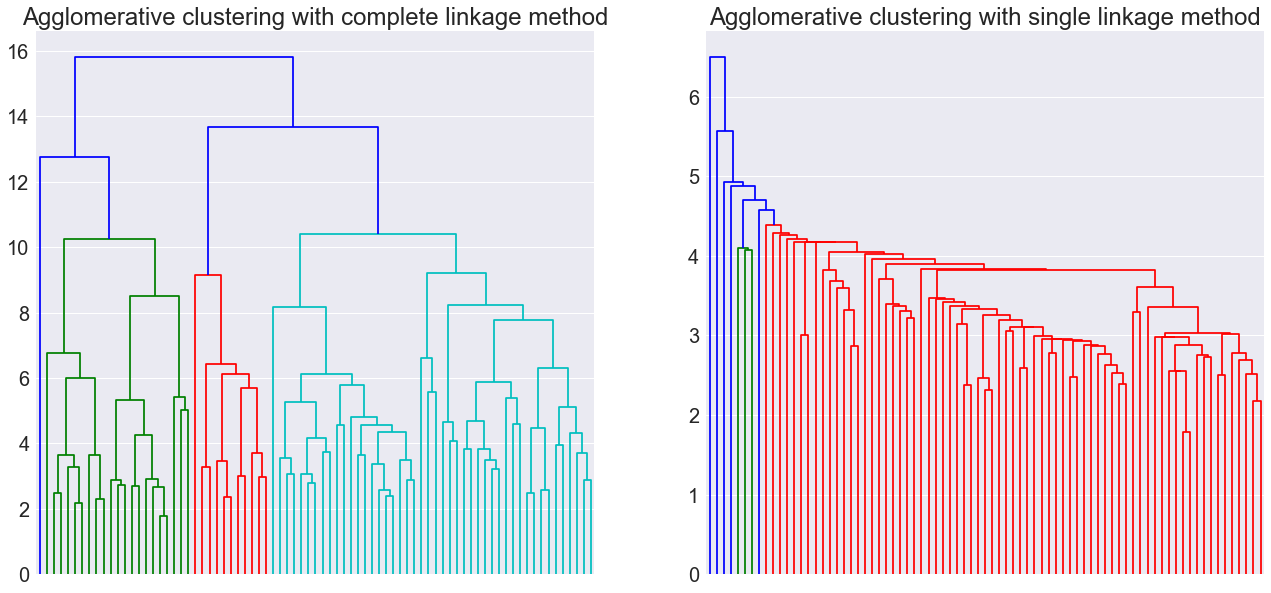

In [24]:
# Calculating dissimilarity matrix using euclidean distance
d = pdist(X_scaled, 'euclidean')

# Different linkage methods
hc1 = linkage(d, 'complete')
hc2 = linkage(d, 'single')

# Visualise with dendrograms
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

dendrogram(hc1, no_labels = True, ax = axes[0])
axes[0].set(title="Agglomerative clustering with complete linkage method")

dendrogram(hc2, no_labels = True, ax = axes[1])
axes[1].set(title="Agglomerative clustering with single linkage method")

plt.show()

<b> Normalized Mutual Information </b>

In [25]:
discrete_columns = ['Outer Regional Australia', 'Inner Regional Australia', 'Major Cities of Australia']

numerical_columns = X.columns.values[:-3]

# making a dataframe for bins
bins_df = pd.DataFrame(columns = numerical_columns)

# printing the ranges for each column
for col in numerical_columns:
    bins = pd.cut(X[col], 4, retbins=True)[-1]
    bins_df[col] = pd.cut(X[col], 4, labels = False)
    print('################# %s #################' % col)
    print('bin# 1: range [%d,%d)' % (bins[0],bins[1]))
    print('bin# 2: range [%d,%d)' % (bins[1],bins[2]))
    print('bin# 3: range [%d,%d)' % (bins[2],bins[3]))
    print('bin# 4: range [%d,%d)' % (bins[3],bins[4]))

################# Percentage of People born overseas #################
bin# 1: range [5,18)
bin# 2: range [18,32)
bin# 3: range [32,46)
bin# 4: range [46,59)
################# Clients that received Alcohol & Drug Treatment Services per 1,000 population #################
bin# 1: range [0,5)
bin# 2: range [5,10)
bin# 3: range [10,15)
bin# 4: range [15,20)
################# Percentage of highly disadvantaged SA1s #################
bin# 1: range [0,19)
bin# 2: range [19,38)
bin# 3: range [38,57)
bin# 4: range [57,76)
################# Percentage of low income families with children #################
bin# 1: range [2,5)
bin# 2: range [5,8)
bin# 3: range [8,12)
bin# 4: range [12,15)
################# Percentage of People with food insecurity #################
bin# 1: range [0,3)
bin# 2: range [3,7)
bin# 3: range [7,10)
bin# 4: range [10,14)
################# Percentage of people who are unable to afford prescribed medication #################
bin# 1: range [0,4)
bin# 2: range [4,8)
bin# 3: r

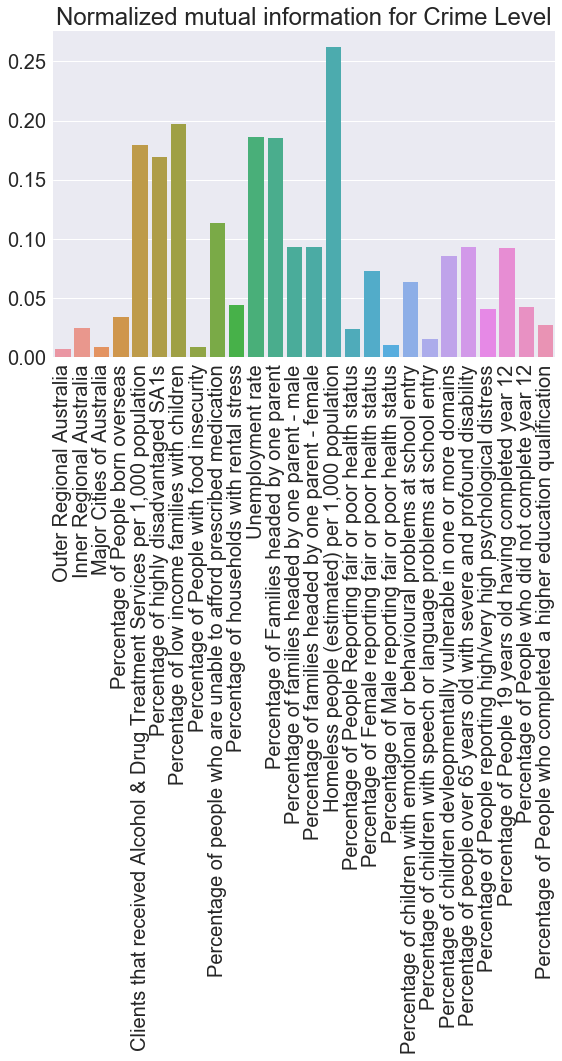

In [26]:
# concatenate the with the values in discrete_columns
bins_df = pd.concat([X[discrete_columns], bins_df], axis = 1)

# appending mutual_info data from the bins_df into the list
mutual_info_cols = []
for col in bins_df.columns:
    mutual_info_cols.append(mutual_info(bins_df[col], y))

# creating dataframe out of the mutual information 
NMI_df = pd.DataFrame(mutual_info_cols, index = bins_df.columns, columns = ['mutual_information'])

# plot
plt.figure(figsize=(9,6))

# visualise with barplot
sns.barplot(NMI_df.index, NMI_df['mutual_information'])

plt.title("Normalized mutual information for Crime Level")
plt.ylabel('')
plt.xticks(rotation=90)

plt.show()

From the NMI, Percentage of Family headed by one parent can also be seen possible cause of the high crime level of LGA. 

<b> Get Training and Testing Values </b>

In [27]:
# getting the values for training and testing
X_train, X_test, y_train, y_test = train_test_split(X.astype(float), y.astype(float), test_size=0.2, random_state = 42)

print("***")
print("Train Test Split Results")
print("X_train matrix:", X_train.shape)
print("y_train labels:", y_train.shape)
print("X_test matrix:", X_test.shape)
print("y_test labels:", y_test.shape)
print("***")

***
Train Test Split Results
X_train matrix: (63, 26)
y_train labels: (63,)
X_test matrix: (16, 26)
y_test labels: (16,)
***


<b> Feature Scaling </b>

In [28]:
standard_scaler = StandardScaler().fit(X_train)

# standardising the X_train and X_test
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

print("***")
print("X_train:  (%.2f,%.2f,%.2f,%.2f)" % (X_train[:,].min(),X_train[:,].max(),X_train[:,].mean(),X_train[:,].std()))
print("X_test:   (%.2f,%.2f,%.2f,%.2f)" % (X_test[:,].min(),X_test[:,].max(),X_test[:,].mean(),X_test[:,].std()))
print("X_scaled: (%.2f,%.2f,%.2f,%.2f)" % (X_scaled[:,].min(),X_scaled[:,].max(),X_scaled[:,].mean(),X_scaled[:,].std()))
print("***")

***
X_train:  (-4.07,5.08,-0.00,1.00)
X_test:   (-2.33,2.91,0.02,0.85)
X_scaled: (-4.45,4.90,0.00,1.00)
***


<b> K-nearest Neighbor Classifier </b>

In [29]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

X_train_pred = knn.predict(X_train)
X_test_pred = knn.predict(X_test)

print("***")
print("Training score: %.2f%%" % (accuracy_score(y_train, X_train_pred) * 100))
print("Testing score: %.2f%%" % (accuracy_score(y_test, X_test_pred) * 100))
print("***")

***
Training score: 90.48%
Testing score: 93.75%
***


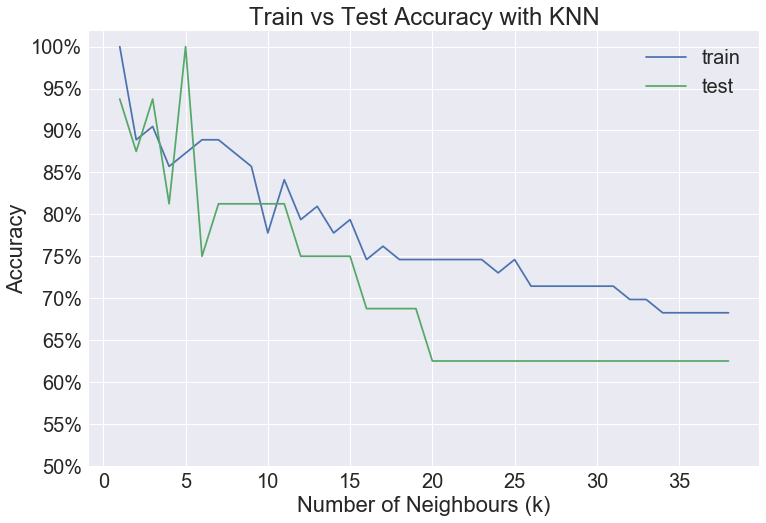

Best value for k is [5, 5] with maximum test accuracy of 100.00%


In [30]:
# k values
ks = range(1,int(len(X)/2))
result_df = pd.DataFrame(index = ks, columns = ['train_result','test_result'])
knn_train_result = []
knn_test_result = []

# appending accuracy scores into the lists
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train) 
    train_pred = knn.predict(X_train)
    test_pred = knn.predict(X_test)
    knn_train_result.append(accuracy_score(y_train, train_pred)* 100)
    knn_test_result.append(accuracy_score(y_test, test_pred)* 100)

result_df['train_result'] = pd.Series(knn_train_result, index = result_df.index)
result_df['test_result'] = pd.Series(knn_test_result, index = result_df.index)

# plotting
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(ks,result_df['train_result'], label = 'train')
ax.plot(ks,result_df['test_result'], label = 'test')
ax.legend()

plt.title("Train vs Test Accuracy with KNN")
plt.xlabel("Number of Neighbours (k)")
plt.ylabel("Accuracy")
plt.yticks([i for i in range(50,105,5)],[str(i) + "%" for i in range(50,105,5)])
plt.show()

# getting the k values which has the highest test accuracy
max_k_values = [i for i in result_df.index if result_df.loc[i]['test_result'] == max(knn_test_result)]

print("Best value for k is [%d, %d] with maximum test accuracy of %.2f%%" % (min(max_k_values), max(max_k_values), 
      max(knn_test_result)))

<b> Decision Tree Classifier </b>

In [31]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
clf = dt.fit(X_train, y_train)

train_pred = dt.predict(X_train)
test_pred = dt.predict(X_test)

print("***")
print("Train accuracy: %.2f%%" % (accuracy_score(y_train, train_pred)*100))
print("Test accuracy: %.2f%%" % (accuracy_score(y_test, test_pred)*100))
print("***")

***
Train accuracy: 100.00%
Test accuracy: 81.25%
***


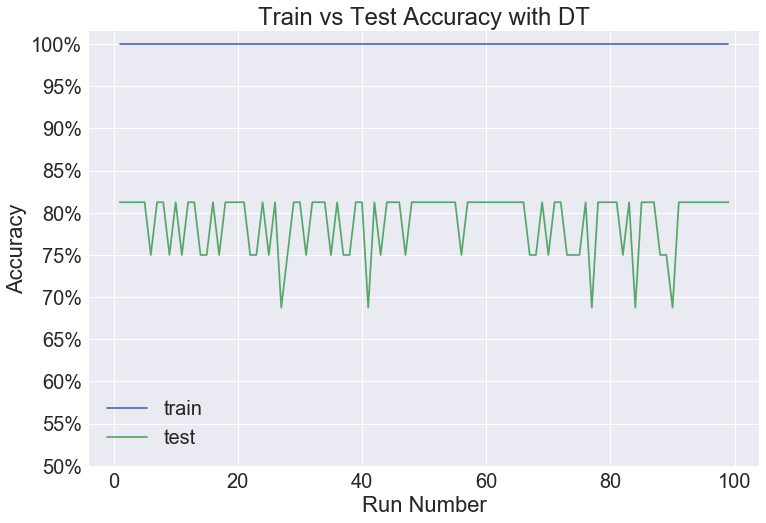

- The maximum test accuracy that can be gained from the decision tree classifier is 81.25%


In [32]:
### Justification

# Simulate tests
index_range = [i for i in range(1,100)]

result_df = pd.DataFrame(index = index_range,columns=['train', 'test'])
dt_train_result = []
dt_test_result = []

# appending accuracy scores into the lists
for i in index_range:
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    test_pred = dt.predict(X_test)
    dt_train_result.append(accuracy_score(y_train, train_pred) * 100)
    dt_test_result.append(accuracy_score(y_test, test_pred)* 100)

result_df['train_result'] = pd.Series(dt_train_result, index = result_df.index)
result_df['test_result'] = pd.Series(dt_test_result, index = result_df.index)
    
# plotting
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(index_range, result_df['train_result'], label = 'train')
ax.plot(index_range, result_df['test_result'], label = 'test')
ax.legend()

plt.title("Train vs Test Accuracy with DT")
plt.xlabel("Run Number")
plt.ylabel("Accuracy")
plt.yticks([i for i in range(50,105,5)],[str(i) + "%" for i in range(50,105,5)])

plt.show()

max_depth = result_df.loc[result_df['test_result'] == result_df['test_result'].max()].index.values

print("- The maximum test accuracy that can be gained from the decision tree classifier is %.2f%%" % max(dt_test_result))



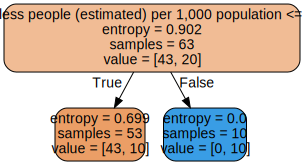

In [33]:
# Visualize the DT 
export_graphviz(DecisionTreeClassifier(criterion='entropy', max_depth = max_depth[0]).fit(X_train, y_train),\
                out_file="mytree.dot",feature_names = X.columns,filled=True,rounded=True)

with open("./mytree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

# Conclusion

From Visualisations, it can be concluded that Crime Level in LGA can be affected by Remoteness area and Police Region. Furthermore it has positive correlation with Unemployment Rate, Number of Homeless People, Poverty, and Alcohol and Drug consumptions. From NMI, it can be seen that LGA has High Crime Level based on some of major factors which have been inspected before, but Broken Family attribute is also found to be the reason of high crime level. The challenge found is in merging the DataFrames since the DataFrames have different format for their potential keys.